In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.scale import LogitScale
import gc
import joblib
import time
import numpy as np
import pandas as pd
import nibabel as nib
import statsmodels.api as sm                                                                                        
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import zscore
from joblib import Parallel, delayed
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
from joblib import load
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from utils import train_data_normalization, Timer, net_size_info, conv2_labels
import os, sys, six 
import scipy as sp
import h5py
import scipy.io as sio
import neuropythy as ny
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from utils import get_roi_data

In [ ]:
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{subspace}-{space}_{newtuning}_newtuning-distance.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)

## 分析十一、量化考察初级视皮层复杂特征调制的视野拓扑组织规律

In [48]:
#路径设置
work_dir = '/nfs/z1/userhome/zzl-xsk/Featurespace'
map_dir = pjoin(work_dir, 'anal/brainmap')
cifti_path = '/nfs/z1/userhome/zzl-xsk/NOD/derivatives/ciftify'
masked_retinopath = pjoin(map_dir, 'masked_retinotopy')
masked_retino_path = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel')
pca_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-pca')
ica_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-ica')
concate_path = pjoin(work_dir, 'prep/roi-concate')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
res_fig_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/results_plots'
savefig_path = pjoin('/nfs/z1/userhome/zzl-xsk/workingdir/nsdretinotopy', 'figures')
os.makedirs(savefig_path, exist_ok=True)
#参数设置
subs = [f'sub-{isub:02d}' for isub in range(1, 10)]
layername = 'googlenet-conv2'
spacename = 'pca'
roiname = 'V3'

### 结果11.1：从特征轴上分析：构建距离矩阵，得到ang ecc redial距离对调谐差异的效应

In [49]:
allsub_weights = np.nan * np.zeros((9 , 3))
for isub, sub in enumerate(subs):
    #读取被试的tuning，并进行标准化
    if spacename == 'raw':
        voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))
    elif spacename == 'pca':
        voxelwise_model = np.load(pjoin(pca_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))
    elif spacename =='ica':
        voxelwise_model = np.load(pjoin(ica_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))
    voxelwise_model = zscore(voxelwise_model, axis=1)
    #读取体素信息，并选取ecc小于8的体素
    voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
    dnn_prf = nib.load(pjoin(masked_retinopath, sub, f'{sub}_new-weighted-masked-dnn-prf.dscalar.nii')).get_fdata()
    ecc_select_voxels = np.where((dnn_prf[0, :] <= 8)==True)[0]
    select_voxels = np.intersect1d(voxels, ecc_select_voxels)
    # select_voxels = select_voxels[np.where(select_voxels < 29706)[0]]
    select_voxel_idx = np.squeeze([np.where(voxels == i)[0] for i in  select_voxels])
    voxelwise_model = voxelwise_model[select_voxel_idx, :]


    corr_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
    distance_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
    ecc_difference_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
    ang_difference_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))


    dnn_ecc = dnn_prf[0, :]
    dnn_ang = dnn_prf[1, :]
    dnn_ang = transfer_ang(dnn_ang)

    corr_matrix = np.corrcoef(voxelwise_model)

    for i, avoxel in enumerate(select_voxels):
        a_weights = voxelwise_model[i, :]
        a_ecc = dnn_ecc[avoxel]
        a_ang = dnn_ang[avoxel]
        a_theta = a_ang * np.pi /180
        a_x, a_y = a_ecc * np.cos(a_theta), a_ecc * np.sin(a_theta)

        for j, bvoxel in enumerate(select_voxels):
            b_weights = voxelwise_model[j, :]
            b_ecc = dnn_ecc[bvoxel]
            b_ang = dnn_ang[bvoxel]
            b_theta = b_ang * np.pi /180
            b_x, b_y = b_ecc * np.cos(b_theta), b_ecc * np.sin(b_theta)

            ecc_difference = abs(a_ecc - b_ecc)
            ecc_difference_matrix[i, j ] = ecc_difference

            ang_difference = ang_difference = abs(a_theta - b_theta)
            ang_difference = (ang_difference) % (np.pi/2)
            ang_difference_matrix[i, j ] = ang_difference

            distance = np.sqrt((a_x - b_x) ** 2 + (a_y - b_y) ** 2)
            distance_matrix[i, j] = distance

    #回归模型
    x1 = zscore(ang_difference_matrix.flatten())
    x2 = zscore(ecc_difference_matrix.flatten())
    x3 = zscore(distance_matrix.flatten())
    X = np.column_stack((x1, x2, x3))
    
    corr_matrix = 1 - corr_matrix
    y = zscore(corr_matrix.flatten())

    lr = LinearRegression()
    lr.fit(X, y)
    weights = lr.coef_
    allsub_weights[isub, :] = weights

In [50]:
stds = np.std(allsub_weights, axis=0)
sems = 1.96 * stds / 3

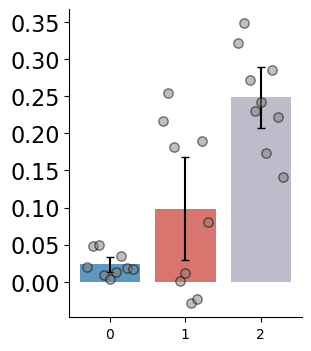

In [51]:
colors= [ '#377fae', '#ce534a', '#aeacbd',]#["#c7522a","#74a892","#008585"]
mean_weights = np.nanmean(allsub_weights, axis=0)
labels = ['ang', 'ecc', 'distance']
width = 0.3
positions = np.arange(len(labels))  # 柱状图的中心位置
offsets = np.linspace(-width, width, 9)  # 等分散点图宽度
fig, ax = plt.subplots(figsize=(3, 4))
plt.bar(labels, mean_weights, yerr=sems, capsize=3,color=colors, alpha=0.8)
#画上每个被试的散点图
for isub, sub_weights in enumerate(allsub_weights):
    for idx, weight in enumerate(sub_weights):
        plt.scatter(positions[idx] + offsets[isub], weight, s=45, color='grey', alpha=0.5, edgecolor='black', linewidth=1, zorder=3)
plt.gcf().set_facecolor('white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.tick_params(axis='x', labelsize=16)
plt.xticks([0,1,2], [0,1,2])
plt.yticks(fontsize=16)
# ax.set_ylabel('Betas', fontsize=14)
# plt.savefig(pjoin(savefig_path, 'betas_bar.png'), dpi=300, bbox_inches='tight')
layer, space = 'conv2', 'pca'
plt.savefig(pjoin(res_fig_dir, f'roi-{roiname}_layer-{layer}_space-{space}_coding-principle-RDM-coef.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)
plt.show()

### 展示调制的变化

In [3]:
def transfer_ang(theta):
    new_theta = 90 - theta
    new_theta = new_theta % 360
    return new_theta
def calculate_draw_matrix(seed_x, seed_y, binsize, x_bins, y_bins, grid_data, average_result):
    seed_x_idx = np.digitize(seed_x, x_bins, right=True) - 1
    seed_y_idx = np.digitize(seed_y, y_bins, right=True) - 1
    seed_weights = average_result[seed_y_idx, seed_x_idx, :]
    seed_weights = np.nan_to_num(seed_weights)

    draw_matrix = np.zeros((binsize, binsize))
    for i in range(binsize):
        for j in range(binsize):
            target_weights = grid_data[i, j, :]
            target_weights = np.nan_to_num(target_weights)
            if np.any(target_weights) and np.any(seed_weights):  # 避免全零向量导致的NaN结果
                corr = np.corrcoef(seed_weights, target_weights)[0, 1]
            else:
                corr = np.nan
            draw_matrix[i, j] = corr
    return draw_matrix

In [52]:
voxel_positions = []
for sub in subs:
    #读取masked prior retinotopy
    dnn_prf = nib.load(pjoin(masked_retinopath, sub, f'{sub}_new-weighted-masked-dnn-prf.dscalar.nii')).get_fdata()
    dnn_ang = dnn_prf[1, :]
    dnn_ang = transfer_ang(dnn_ang)
    dnn_ecc = dnn_prf[0, :]
    #确定我们要使用的voxels
    voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
    ecc_select_voxels = np.where((dnn_prf[0, :] <= 8)==True)[0]
    select_voxels = np.intersect1d(voxels, ecc_select_voxels)
    select_voxel_idx = np.squeeze([np.where(voxels == i)[0] for i in  select_voxels])
    #读取voxelwise model
    if spacename == 'raw':
        voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))[select_voxel_idx, :]
    elif spacename == 'pca':
        voxelwise_model = np.load(pjoin(pca_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))[select_voxel_idx, :]
    elif spacename =='ica':
        voxelwise_model = np.load(pjoin(ica_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))[select_voxel_idx, :]
    voxelwise_model = zscore(voxelwise_model , axis=1)
    #遍历体素和种子体素计算tuning的相关
    for i, voxel in enumerate(select_voxels):
        #计算目标体素加工的视野位置
        voxel_weights = voxelwise_model[i, :]
        voxel_ang = dnn_ang[voxel]
        voxel_ecc = dnn_ecc[voxel]
        theta = voxel_ang * np.pi/180
        voxel_x, voxel_y = voxel_ecc * np.cos(theta), voxel_ecc * np.sin(theta)
        voxel_positions.append([voxel_x, voxel_y, voxel_weights])

In [93]:
#计算出binned weights matrix
binsize = 40
x_bins = np.linspace(-8, 8, binsize)
y_bins = np.linspace(8, -8, binsize)
xx, yy = np.meshgrid(x_bins, y_bins)
grid_data = np.zeros((len(x_bins), len(y_bins), 63))
counts = np.zeros((len(x_bins), len(y_bins)))

voxel_positions1 = np.array(voxel_positions)
xs = voxel_positions1[:, 0]
ys = voxel_positions1[:, 1]
weights = voxel_positions1[:, 2]

for x, y, weight in zip(xs, ys, weights):
    x_idx = np.digitize(x, x_bins, right=True) - 1
    y_idx = np.digitize(y, y_bins, right=True) - 1
    if 0 <= x_idx < grid_data.shape[1] and 0 <= y_idx < grid_data.shape[0]:
        grid_data[y_idx, x_idx, :] += weight
        counts[y_idx, x_idx] += 1
counts_expanded = counts[:, :, np.newaxis]
# 使用 np.divide 安全地进行除法，当分母为0时，使用 np.zeros_like 创建一个全0数组作为默认结果
average_result = np.divide(grid_data, counts_expanded, out=np.zeros_like(grid_data), where=(counts_expanded!=0))
#选取种子bin
radius = 1
center_x = 5 #0.5 #5.6 # -5#
center_y = -5 # -0.5#-5.6 # 5#
center_x_idx  = np.digitize(center_x, x_bins, right=True) - 1
center_y_idx  = np.digitize(center_y, y_bins, right=True) - 1

seeds = [(center_x_idx, center_y_idx)]
for i in range(max(0, center_y_idx - radius), min(binsize, center_y_idx + radius + 1)):
    for j in range(max(0, center_x_idx - radius), min(binsize, center_x_idx + radius + 1)):
        if np.sqrt((i - center_y_idx) ** 2 + (j - center_x_idx) ** 2) <= radius:
            seeds.append((x_bins[j], y_bins[i]))
        
# 存储所有相关性矩阵
all_draw_matrices = []

# 对于每个种子点计算相关性矩阵
for seed_x, seed_y in seeds:
    draw_matrix = calculate_draw_matrix(seed_x, seed_y, binsize, x_bins, y_bins, grid_data, average_result)
    all_draw_matrices.append(draw_matrix)

# 计算所有相关性矩阵的平均值
mean_draw_matrix = np.nanmean(all_draw_matrices, axis=0)

<ipython-input-93-1f6ef0d5e0b8>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  voxel_positions1 = np.array(voxel_positions)
<ipython-input-93-1f6ef0d5e0b8>:45: RuntimeWarning: Mean of empty slice
  mean_draw_matrix = np.nanmean(all_draw_matrices, axis=0)


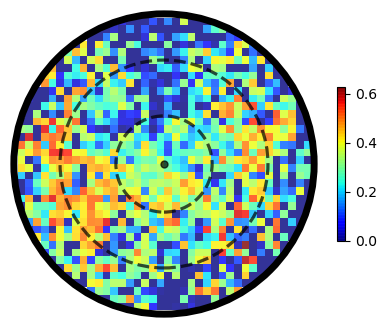

In [95]:
import matplotlib.patches as patches
mean_draw_matrix = np.nan_to_num(mean_draw_matrix)
fig, ax =plt.subplots(figsize=(10/2, 8/2))

mean_draw_matrix[np.where((xx**2 + yy**2)>64)] = np.nan
# plt.imshow(mean_draw_matrix, extent=[-8, 8, -8, 8], cmap='jet', vmin=0, vmax=0.5, alpha=0.8)

radius = 7.8  # 半径大小，根据你的需求调整
radius1 = 2.5
radius2 = 5.4
# radius3 = 6
circle = patches.Circle((0, 0), radius, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=2)

# 将圆形作为裁剪区域添加到axes中
ax.add_patch(circle)
# im = ax.imshow(mean_draw_matrix, extent=[-8, 8, -8, 8], cmap='jet', vmin=0.2, vmax=0.8, alpha=0.8)
im = ax.imshow(mean_draw_matrix, extent=[-8, 8, -8, 8], cmap='jet', vmin=0, alpha=0.8)
im.set_clip_path(circle)
# 添加黑色边框
circle_edge = patches.Circle((0, 0), radius, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=5)
circle1 = patches.Circle((0, 0), radius1, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=2.3, linestyle='--', alpha=0.7)
circle2 = patches.Circle((0, 0), radius2, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=2.3, linestyle='--', alpha=0.7)
# circle3 = patches.Circle((0, 0), radius3, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=3, linestyle='--')

ax.add_patch(circle_edge)
ax.add_patch(circle1)
ax.add_patch(circle2)
# ax.add_patch(circle3)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.5)  # 设置为水平方向'horizontal'
# cbar.set_ticks([0.3, 0.55, 0.8])
ax.plot(0, 0, 'ko', markersize=5, alpha=0.7)
plt.axis('off')
plt.gcf().set_facecolor('white')
plt.savefig(pjoin(res_fig_dir, f'roi-{roiname}_layer-{layer}_space-{space}_coding-principle-ecc{center_x}.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)

# plt.savefig(pjoin(savefig_path, '5.6.png'), dpi=300, bbox_inches='tight')
plt.show()
# colorbar()

In [96]:
# V1 channels
# channels = [ 0,  4,  5,  9, 10, 11, 18, 21, 23, 24, 25, 26, 27, 30, 31, 32, 36, 37, 41, 44, 48, 52, 53, 55, 59, 62]
if roiname == 'V1':
    channels = [ 0, 6, 11, 23, 25, 1, 41, 20, 13, 59, 30, 24, 19, 62, 3, 12, 42, 27, 43, 56, 57, 53]
if roiname == 'V2':
    channels = [ 0, 6, 1, 23, 3, 59, 27, 13, 20, 43, 11, 30, 56, 57, 16, 22, 44, 62, 42, 54, 61, 48, 50, 12, 34, 53]
if roiname == 'V3':
    channels = [ 0, 6, 3, 59, 20, 23, 13, 30, 11, 43, 56, 1, 57, 42, 27, 62, 53, 48, 54]
print(sorted(channels),len(channels))

[0, 1, 3, 6, 11, 13, 20, 23, 27, 30, 42, 43, 48, 53, 54, 56, 57, 59, 62] 19


In [97]:
from sklearn.linear_model import LinearRegression
sigchannel_betas = np.nan * np.zeros((9, len(channels), 3))
similaritys = np.nan * np.zeros((9, len(channels)))
for ichannel, channel in enumerate(channels):
    for isub, sub in enumerate(subs):
        #读取被试的tuning，并进行标准化
        voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))[:, channel]
        # voxelwise_model = zscore(voxelwise_model, axis=1)
        #读取体素信息，并选取ecc小于8的体素
        voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
        dnn_prf = nib.load(pjoin(masked_retino_path, sub, f'{sub}_new-weighted-masked-dnn-prf.dscalar.nii')).get_fdata()
        ecc_select_voxels = np.where((dnn_prf[0, :] <= 8)==True)[0]
        select_voxels = np.intersect1d(voxels, ecc_select_voxels)
        # select_voxels = select_voxels[np.where(select_voxels < 29706)[0]]
        select_voxel_idx = np.squeeze([np.where(voxels == i)[0] for i in  select_voxels])
        voxelwise_model = voxelwise_model[select_voxel_idx]


        similarity_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
        distance_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
        ecc_difference_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
        ang_difference_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))


        dnn_ecc = dnn_prf[0, :]
        dnn_ecc[np.where(dnn_ecc > 8)[0]] = np.nan
        dnn_ang = dnn_prf[1, :]
        dnn_ang = transfer_ang(dnn_ang)

        similarity_matrix = np.abs(voxelwise_model[:, np.newaxis] - voxelwise_model[np.newaxis, :])

        ecc = dnn_ecc[select_voxels]
        ang_deg = dnn_ang[select_voxels]

        # 将角度从度转换为弧度
        theta = ang_deg * np.pi / 180

        # 计算笛卡尔坐标
        x = ecc * np.cos(theta)
        y = ecc * np.sin(theta)

        # 使用外积来计算所有组合的偏心率差的绝对值
        ecc_difference_matrix = np.abs(ecc[:, np.newaxis] - ecc)

        # 计算所有组合的角度差
        ang_difference_matrix = np.abs(theta[:, np.newaxis] - theta)
        ang_difference_matrix = np.mod(ang_difference_matrix, np.pi/2)

        # 计算所有点对的欧式距离
        x_diff = x[:, np.newaxis] - x
        y_diff = y[:, np.newaxis] - y
        distance_matrix = np.sqrt(x_diff**2 + y_diff**2)

        #回归模型
        x1 = zscore(ang_difference_matrix.flatten())
        x2 = zscore(ecc_difference_matrix.flatten())
        x3 = zscore(distance_matrix.flatten())
        X = np.column_stack((x1, x2, x3))

        Y = zscore(similarity_matrix.flatten())

        lr = LinearRegression()
        lr.fit(X, Y)
        weights = lr.coef_
        sigchannel_betas[isub, ichannel, :] = weights

t-test

In [98]:
results = np.empty((len(channels), 3), dtype='object')

for i in range(len(channels)):  # 对于每个feature
    for j in range(3):  # 对于每个线性模型的权重
        weights = sigchannel_betas[:, i, j]  # 提取所有被试的权重
        t_stat, p_value = stats.ttest_1samp(weights, 0)  # 进行t检验
        results[i, j] = (p_value)  # 保存t统计量和p值

In [45]:
sigchannel_betas[:, channels.index(34), 0].std()

0.022261280188448918

In [99]:
set(np.array(channels)) - set(np.array(channels)[np.where((results[:, 2] < 0.05))]), len(channels)

({3}, 19)

In [100]:
[np.sum(results[_, :] < 0.05) for _ in range(len(channels)) ] 

[1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [101]:
ang_channels = np.array(channels)[np.where((results[:, 0] <= 0.05) & (results[:, 1] > 0.05) & (results[:, 2] > 0.05))[0]]
ecc_channels = np.array(channels)[np.where((results[:, 1] <= 0.05) & (results[:, 0] > 0.05) & (results[:, 2] > 0.05))[0]]
distance_channels = np.array(channels)[np.where((results[:, 2] <= 0.05) & (results[:, 0] > 0.05) & (results[:, 1] > 0.05))[0]]

angecc_channels = np.array(channels)[np.where((results[:, 0] <= 0.05) & (results[:, 1] <= 0.05) & (results[:, 2] > 0.05))[0]]
eccdistance_channels = np.array(channels)[np.where((results[:, 0] > 0.05) & (results[:, 1] <= 0.05) & (results[:, 2] <= 0.05))[0]]
angdistance_channels = np.array(channels)[np.where((results[:, 0] <= 0.05) & (results[:, 1] > 0.05) & (results[:, 2] <= 0.05))[0]]
all_channels = np.array(channels)[np.where((results[:, 0] <= 0.05) & (results[:, 1] <= 0.05) & (results[:, 2] <= 0.05))[0]]
ang_channels, ecc_channels, distance_channels, angecc_channels,  angdistance_channels,  eccdistance_channels, all_channels, \
len(ang_channels), len(ecc_channels), len(distance_channels), len(angecc_channels),  len(angdistance_channels),  len(eccdistance_channels), len(all_channels)

(array([3]),
 array([], dtype=int64),
 array([ 0,  6, 59, 20, 13, 30, 11, 43, 56,  1, 57, 42, 27, 62, 53, 48, 54]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([23]),
 1,
 0,
 17,
 0,
 0,
 0,
 1)

In [33]:
sorted([ 0,  6,  3, 59, 20, 43, 11, 30, 57, 22, 44, 62, 42, 54, 61, 48, 12, 53])

[0, 3, 6, 11, 12, 20, 22, 30, 42, 43, 44, 48, 53, 54, 57, 59, 61, 62]

In [80]:
voxel_positions = []
channel = 25
for sub in subs:
    #读取masked prior retinotopy
    dnn_prf = nib.load(pjoin(masked_retinopath, sub, f'{sub}_new-weighted-masked-dnn-prf.dscalar.nii')).get_fdata()
    dnn_ang = dnn_prf[1, :]
    dnn_ang = transfer_ang(dnn_ang)
    dnn_ecc = dnn_prf[0, :]
    #读取voxelwise model
    if spacename == 'raw':
        voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))
    elif spacename == 'pca':
        voxelwise_model = np.load(pjoin(pca_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))
        test_corr = np.load(pjoin(pca_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-test-cor.npy'))
    elif spacename =='ica':
        voxelwise_model = np.load(pjoin(ica_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))
    #确定我们要使用的voxels
    voxels = set(np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy')))
    ecc_select_voxels = set(np.where((dnn_prf[0, :] <= 8)==True)[0])
    corr_select_voxels = set(np.array(list(voxels))[np.where(test_corr > 0)[0]])
    select_voxels = voxels.intersection(ecc_select_voxels, corr_select_voxels)
    # voxelwise_model = zscore(voxelwise_model , axis=0)
    select_voxels = np.array(list(select_voxels))
    voxels = np.array(list(voxels))
    select_voxel_idx = np.where(np.in1d(voxels, select_voxels))[0]
    voxelwise_model = voxelwise_model[select_voxel_idx, channel]

    for i, voxel in enumerate(select_voxels):
        #计算目标体素加工的视野位置
        voxel_weight = voxelwise_model[i]
        voxel_ang = dnn_ang[voxel]
        voxel_ecc = dnn_ecc[voxel]
        theta = voxel_ang * np.pi/180
        voxel_x, voxel_y = voxel_ecc * np.cos(theta), voxel_ecc * np.sin(theta)
        voxel_positions.append([voxel_x, voxel_y, voxel_weight])

<ipython-input-6-6250348124bd>:3: RuntimeWarning: invalid value encountered in remainder
  new_theta = new_theta % 360


In [102]:
# 把每个被试的
voxelmodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-pca')
voxelpath = pjoin(work_dir, 'prep/roi-concate/')
retinopath = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')

layer = 'conv2'
concatdata = {}
channels = np.array(distance_channels.tolist() + all_channels.tolist() + ang_channels.tolist())#angdistance_channels.tolist()+eccdistance_channels.tolist()
for ichannel, channel in enumerate(channels):
    feature_tunings, voxels, modelrs, coefps= np.array([]), np.array([]), np.array([]), np.array([])
    retino_regressors =  np.array([[],[]]).T
    
    for sub in [f'sub-0{_+1}' for _ in range(9)]:
        voxel = np.load(pjoin(voxelpath, f'{sub}/{sub}_layer-googlenet-{layer}_V1-voxel.npy'))
        model = np.load(pjoin(voxelmodel_path, f'{sub}/googlenet-{layer}/{sub}_V1-fullm-coef.npy'))
        model = zscore(model, axis=0)
        coefp = np.load(pjoin(voxelmodel_path, f'{sub}/googlenet-{layer}/{sub}_V1-fullm-p.npy'))
        modelr = np.load(pjoin(voxelmodel_path, f'{sub}/googlenet-{layer}/{sub}_V1-test-cor.npy'))
        # shuffler = np.percentile(np.load(pjoin(voxelmodel_path, f'shuffleperformance/{sub}/googlenet-{layer}/{sub}_V1-shuffle-corrs.npy')), 95, axis=1)
        retino_file = pjoin(retinopath, f'{sub}/{sub}_new-weighted-masked-dnn-prf.dscalar.nii')
        # retino = nib.load(pjoin(retinopath, f'{sub}/{sub}_masked-prior-prf.dscalar.nii')).get_fdata()
        retino = nib.load(retino_file).get_fdata()
        retino = retino[:, voxel]
        # slection by ecc, abondon those too far
        if 'prior' in retino_file:
            valid_indx = np.where(retino[1]<12)[0]
        else:
            valid_indx = np.where(retino[0]<12)[0]
        # significant_voxel = np.where(modelr > shuffler)[0]
        # valid_voxels = np.intersect1d(valid_indx, significant_voxel)
        valid_voxels = valid_indx
        
        model = model[valid_voxels,:]
        coefp = coefp[valid_voxels,channel]
        retino = retino[:, valid_voxels]
        voxel = voxel[valid_voxels]
        modelr = modelr[valid_voxels]
        # shuffler = shuffler[valid_voxels]
        if 'prior' in retino_file:
            retino_regressor = np.c_[convert_ang(retino[0]), retino[1]]
        else:
            retino_regressor = np.c_[retino[1], retino[0]]
        # feature_tuning = model[:,channel]
        feature_tuning = zscore(model[:,channel])
        retino_regressors = np.concatenate([retino_regressors, retino_regressor])
        feature_tunings = np.concatenate([feature_tunings, feature_tuning])
        voxels = np.concatenate([voxels, voxel])
        coefps = np.concatenate([coefps, coefp])
        modelrs = np.concatenate([modelrs, modelr])
        # shufflers = np.concatenate([shufflers, shuffler])
        # # sub plots
        # significant_voxel = np.where(modelr > shuffler)[0]
        # x = np.cos(retino_regressor[significant_voxel, 0]) * retino_regressors[significant_voxel, 1]
        # y = np.sin(retino_regressor[significant_voxel, 0]) * retino_regressors[significant_voxel, 1]
        # c = feature_tunings[significant_voxel]
        # plt.figure(figsize=(4,4))
        # plt.scatter(x,y,s=10, c=c, alpha=0.7, cmap='rainbow')
        # plt.axis('equal')
        # plt.title(f'{sub}-channel-{channel}')
        # plt.show()

    concatdata[channel] = (retino_regressors, feature_tunings, voxels, modelrs,  coefps)

In [73]:
import matplotlib
matplotlib.__version__

'3.3.2'

[ 0  6 59 20 13 30 11 43 56  1 57 42 27 62 53 48 54 23  3]


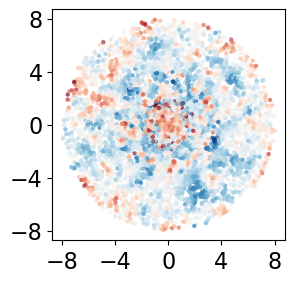

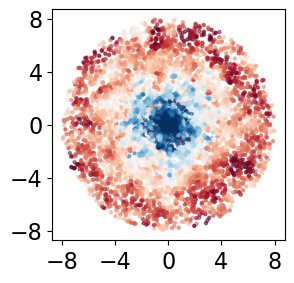

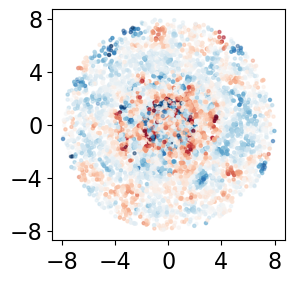

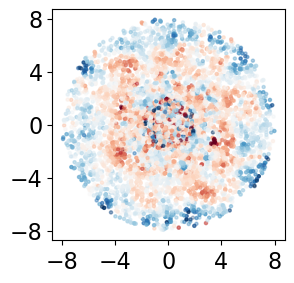

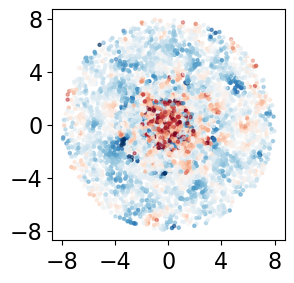

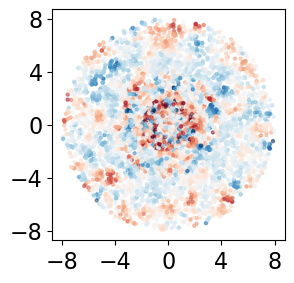

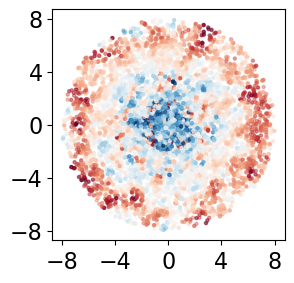

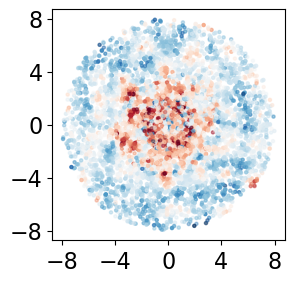

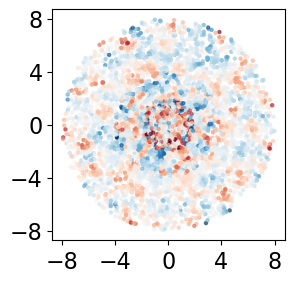

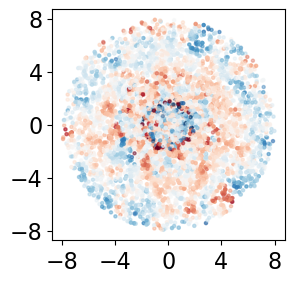

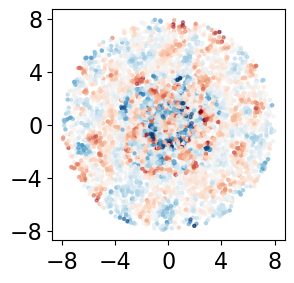

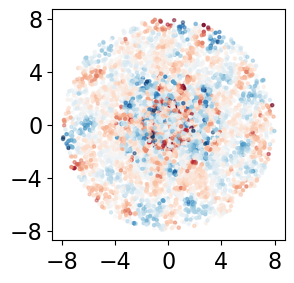

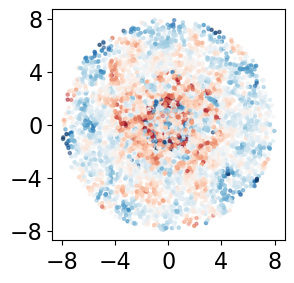

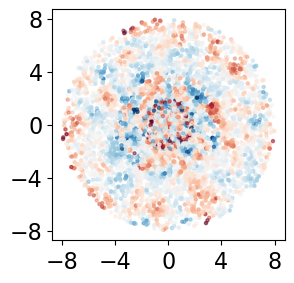

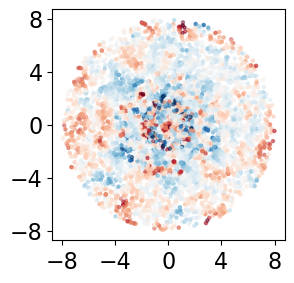

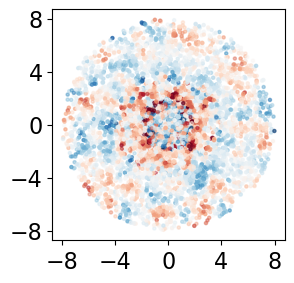

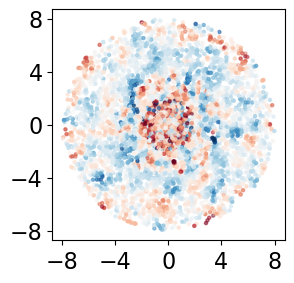

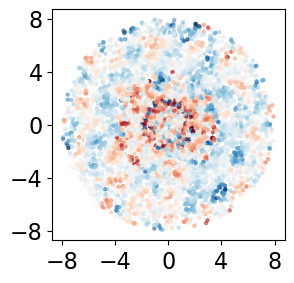

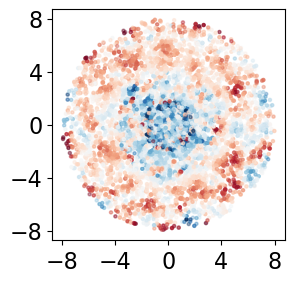

In [103]:
from matplotlib.colors import Normalize
print(channels)
# channels = eccdistance_channels
for channel in channels:
    retino_regressors, feature_tunings, voxels, modelrs,  coefps = concatdata[channel]
    significant_voxels = np.where(retino_regressors[:,1] < 8)[0] # np.where(coefps < 0.05)[0]  #np.where(modelrs > shufflers)[0]
    x = np.cos(retino_regressors[significant_voxels, 0]) * retino_regressors[significant_voxels, 1]
    y = np.sin(retino_regressors[significant_voxels, 0]) * retino_regressors[significant_voxels, 1]
    c = feature_tunings[significant_voxels]
    modelr_values = modelrs[significant_voxels]
    # plt.scatter(x,y,s=10, c=c, alpha=0.7, cmap='RdBu_r', vmax=2, vmin=-2)
    # plt.colorbar()
    # plt.axis('equal')
    # plt.show()
    from scipy.spatial import cKDTree
    data = np.c_[x,y,c]
    tree = cKDTree(data[:, :2])
    
    averaged_responses = np.zeros(len(data))  # 初始化平均响应值数组

    for i in range(len(data)):
        if np.sum(data[i, :2]**2) <= 4:
            radius = 0.1  # 定义搜索邻居的半径
        elif np.sum(data[i, :2]**2) > 16:
            radius = 0.6
        else:
            radius = 0.3
        # 找出第i个点半径内的所有点的索引
        indices = tree.query_ball_point(data[i, :2], r=radius)
        
        # 计算这些点的响应值的平均
        averaged_responses[i] = data[indices, 2].mean()
    alpha_values = 0.2 + 0.8 * (modelr_values - np.min(modelr_values)) / (np.max(modelr_values) - np.min(modelr_values))
    # 创建一个标准化对象
    vmin, vmax = -1, 1
    norm = Normalize(vmin=vmin, vmax=vmax)
    # 创建一个颜色映射对象
    cmap = plt.cm.RdBu_r
    # 将数据标准化并映射到颜色图上
    colors = cmap(norm(averaged_responses))
    colors[:, -1] = alpha_values  # 设置颜色数组的 alpha 通道
    plt.style.use('default')
    plt.figure(figsize=(3,3))
    plt.scatter(x, y, s=5, color=colors, cmap='RdBu_r')#alpha=0.9, vmin=-1, vmax=1
    # cbar = plt.colorbar()
    # cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    # plt.xlim([-8, 8])
    # plt.ylim([-8, 8])
    # plt.yticks([-8,-6,-4,-2,0,2,4,6,8])
    # plt.xticks([-8,-6,-4,-2,0,2,4,6,8])
    plt.yticks([-8,-4,0,4,8], fontsize=16)
    plt.xticks([-8,-4,0,4,8], fontsize=16)
    # plt.xlabel(f'F-{channel}')
    # plt.axis('off')
    # plt.axis('equal')
    if channel in distance_channels.tolist(): label = 'localized'
    if channel in eccdistance_channels.tolist(): label = 'eccbiased'
    if channel in angdistance_channels.tolist(): label = 'anisotropic'
    if channel in ang_channels.tolist(): label = 'anibutnonear'
    if channel in all_channels.tolist(): label = 'eccanisotropic'
    savepath = pjoin(res_fig_dir, f'codingprinciple/{roiname}')
    os.makedirs(savepath, exist_ok=True)
    layer, space = 'conv2', 'pca'
    plt.savefig(pjoin(savepath, f'roi-{roiname}_layer-{layer}_space-{space}_F-{channel}_{label}-coding-principle.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)
    plt.show()

### roi间 bin内平均调制的cos距离矩阵

In [4]:
def transfer_ang(theta):
    new_theta = 90 - theta
    new_theta = new_theta % 360
    return new_theta

In [5]:
allvoxel_positions = []
rois = ['V1', 'V2', 'V3']
for roi in rois:
    voxel_positions = []
    for sub in subs:
        #读取masked prior retinotopy
        dnn_prf = nib.load(pjoin(masked_retinopath, sub, f'{sub}_new-weighted-masked-dnn-prf.dscalar.nii')).get_fdata()
        dnn_ang = dnn_prf[1, :]
        dnn_ang = transfer_ang(dnn_ang)
        dnn_ecc = dnn_prf[0, :]
        #确定我们要使用的voxels
        voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roi}-voxel.npy'))
        ecc_select_voxels = np.where((dnn_prf[0, :] <= 8)==True)[0]
        select_voxels = np.intersect1d(voxels, ecc_select_voxels)
        select_voxel_idx = np.squeeze([np.where(voxels == i)[0] for i in  select_voxels])
        #读取voxelwise model
        if spacename == 'raw':
            voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roi}-fullm-coef.npy'))[select_voxel_idx, :]
        elif spacename == 'pca':
            voxelwise_model = np.load(pjoin(pca_voxelwisemodel_path, sub, f'{layername}/{sub}_{roi}-fullm-coef.npy'))[select_voxel_idx, :]
        elif spacename =='ica':
            voxelwise_model = np.load(pjoin(ica_voxelwisemodel_path, sub, f'{layername}/{sub}_{roi}-fullm-coef.npy'))[select_voxel_idx, :]
        voxelwise_model = zscore(voxelwise_model , axis=1)
        #遍历体素和种子体素计算tuning的相关
        for i, voxel in enumerate(select_voxels):
            #计算目标体素加工的视野位置
            voxel_weights = voxelwise_model[i, :]
            voxel_ang = dnn_ang[voxel]
            voxel_ecc = dnn_ecc[voxel]
            theta = voxel_ang * np.pi/180
            voxel_x, voxel_y = voxel_ecc * np.cos(theta), voxel_ecc * np.sin(theta)
            voxel_positions.append([voxel_x, voxel_y, voxel_weights])
    allvoxel_positions.append(voxel_positions)

In [6]:
#计算出binned weights matrix
binsize = 40
x_bins = np.linspace(-8, 8, binsize)
y_bins = np.linspace(8, -8, binsize)
xx, yy = np.meshgrid(x_bins, y_bins)
v1_grid_data = np.zeros((len(x_bins), len(y_bins), 63))
v1_counts = np.zeros((len(x_bins), len(y_bins)))

v1_voxel_positions = np.array(allvoxel_positions[0])
v1_xs = v1_voxel_positions[:, 0]
v1_ys = v1_voxel_positions[:, 1]
v1_weights = v1_voxel_positions[:, 2]

for x, y, weights in zip(v1_xs, v1_ys, v1_weights):
    x_idx = np.digitize(x, x_bins, right=True) - 1
    y_idx = np.digitize(y, y_bins, right=True) - 1
    if 0 <= x_idx < v1_grid_data.shape[1] and 0 <= y_idx < v1_grid_data.shape[0]:
        v1_grid_data[y_idx, x_idx, :] += weights
        v1_counts[y_idx, x_idx] += 1
v1_counts_expanded = v1_counts[:, :, np.newaxis]
# 使用 np.divide 安全地进行除法，当分母为0时，使用 np.zeros_like 创建一个全0数组作为默认结果
v1_average_result = np.divide(v1_grid_data, v1_counts_expanded, out=np.zeros_like(v1_grid_data), where=(v1_counts_expanded!=0))



v2_grid_data = np.zeros((len(x_bins), len(y_bins), 63))
v2_counts = np.zeros((len(x_bins), len(y_bins)))

v2_voxel_positions = np.array(allvoxel_positions[1])
v2_xs = v2_voxel_positions[:, 0]
v2_ys = v2_voxel_positions[:, 1]
v2_weights = v2_voxel_positions[:, 2]

for x, y, weights in zip(v2_xs, v2_ys, v2_weights):
    x_idx = np.digitize(x, x_bins, right=True) - 1
    y_idx = np.digitize(y, y_bins, right=True) - 1
    if 0 <= x_idx < v2_grid_data.shape[1] and 0 <= y_idx < v2_grid_data.shape[0]:
        v2_grid_data[y_idx, x_idx, :] += weights
        v2_counts[y_idx, x_idx] += 1
v2_counts_expanded = v2_counts[:, :, np.newaxis]
# 使用 np.divide 安全地进行除法，当分母为0时，使用 np.zeros_like 创建一个全0数组作为默认结果
v2_average_result = np.divide(v2_grid_data, v2_counts_expanded, out=np.zeros_like(v2_grid_data), where=(v2_counts_expanded!=0))



v3_grid_data = np.zeros((len(x_bins), len(y_bins), 63))
v3_counts = np.zeros((len(x_bins), len(y_bins)))

v3_voxel_positions = np.array(allvoxel_positions[2])
v3_xs = v3_voxel_positions[:, 0]
v3_ys = v3_voxel_positions[:, 1]
v3_weights = v3_voxel_positions[:, 2]

for x, y, weights in zip(v3_xs, v3_ys, v3_weights):
    x_idx = np.digitize(x, x_bins, right=True) - 1
    y_idx = np.digitize(y, y_bins, right=True) - 1
    if 0 <= x_idx < v3_grid_data.shape[1] and 0 <= y_idx < v3_grid_data.shape[0]:
        v3_grid_data[y_idx, x_idx, :] += weights
        v3_counts[y_idx, x_idx] += 1
v3_counts_expanded = v3_counts[:, :, np.newaxis]
# 使用 np.divide 安全地进行除法，当分母为0时，使用 np.zeros_like 创建一个全0数组作为默认结果
v3_average_result = np.divide(v3_grid_data, v3_counts_expanded, out=np.zeros_like(v3_grid_data), where=(v3_counts_expanded!=0))

<ipython-input-6-59101b05f539>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v1_voxel_positions = np.array(allvoxel_positions[0])
<ipython-input-6-59101b05f539>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v2_voxel_positions = np.array(allvoxel_positions[1])
<ipython-input-6-59101b05f539>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the

In [18]:
corr_matrix = np.nan * np.zeros((binsize ,binsize))
for i in range(binsize):
    for j in range(binsize):
        v1w = v1_average_result[i, j, :]
        v2w = v2_average_result[i, j, :]
        corr = np.corrcoef(v1w, v2w)[0, 1]
        corr_matrix[i, j] = corr
corr_matrix = np.nan_to_num(corr_matrix)

# corr_matrix = np.nan * np.zeros((binsize ,binsize))
# for i in range(binsize):
#     for j in range(binsize):
#         vaw = v2_average_result[i, j, :]
#         vbw = v3_average_result[i, j, :]
#         corr = np.corrcoef(vaw, vbw)[0, 1]
#         corr_matrix[i, j] = corr
# corr_matrix = np.nan_to_num(corr_matrix)

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


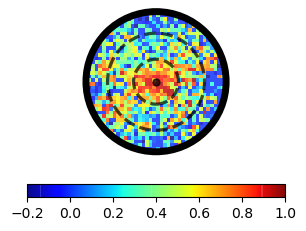

In [28]:
import matplotlib.patches as patches

mean_draw_matrix = np.nan_to_num(corr_matrix)
plt.style.use('default')
fig, ax =plt.subplots(figsize=(10/3, 8/3))

corr_matrix[np.where((xx**2 + yy**2)>64)] = np.nan
# plt.imshow(mean_draw_matrix, extent=[-8, 8, -8, 8], cmap='jet', vmin=0, vmax=0.5, alpha=0.8)

radius = 7.8  # 半径大小，根据你的需求调整
radius1 = 2.5
radius2 = 5.4
# radius3 = 6
circle = patches.Circle((0, 0), radius, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=2)

# 将圆形作为裁剪区域添加到axes中
ax.add_patch(circle)
im = ax.imshow(corr_matrix, extent=[-8, 8, -8, 8], cmap='jet', vmin=-0.2, vmax=1, alpha=0.8)
im.set_clip_path(circle)
# 添加黑色边框
circle_edge = patches.Circle((0, 0), radius, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=5)
circle1 = patches.Circle((0, 0), radius1, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=2.3, linestyle='--', alpha=0.7)
circle2 = patches.Circle((0, 0), radius2, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=2.3, linestyle='--', alpha=0.7)
# circle3 = patches.Circle((0, 0), radius3, transform=ax.transData, clip_on=False, edgecolor='black', facecolor='none', linewidth=3, linestyle='--')

ax.add_patch(circle_edge)
ax.add_patch(circle1)
ax.add_patch(circle2)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal')  # 设置为水平方向, 

ax.plot(0, 0, 'ko', markersize=5, alpha=0.7)
plt.axis('off')
plt.gcf().set_facecolor('white')
layer = 'conv2'
space = 'pca'
roi = 'v1v2'
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{space}_{roi}_hierachical-distance-cbar.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)
plt.show()
# plt.colorbar()

In [22]:
corr_matrix = np.nan * np.zeros((binsize ,binsize))
for i in range(binsize):
    for j in range(binsize):
        v1w = v1_average_result[i, j, :]
        v2w = v2_average_result[i, j, :]
        corr = np.corrcoef(v1w, v2w)[0, 1]
        corr_matrix[i, j] = corr
corr_matrix_v1v2 = np.nan_to_num(corr_matrix)

corr_matrix = np.nan * np.zeros((binsize ,binsize))
for i in range(binsize):
    for j in range(binsize):
        vaw = v2_average_result[i, j, :]
        vbw = v3_average_result[i, j, :]
        corr = np.corrcoef(vaw, vbw)[0, 1]
        corr_matrix[i, j] = corr
corr_matrix_v2v3 = np.nan_to_num(corr_matrix)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [23]:
# Calculate exponential bin edges within 0 to 12 degrees
num_bins = 9
max_eccentricity = 8
base = np.exp(np.log(max_eccentricity) / (num_bins - 1))
bin_edges = np.array([base ** i - 1 for i in range(num_bins)])
bin_edges[-1] = max_eccentricity  # Ensure the last bin edge exactly equals 12
bin_edges[0] = 0  # Ensure the first bin edge starts at 0
corr_matrices = [corr_matrix_v1v2, corr_matrix_v2v3]
eccbin_corr_mean = np.zeros((2, num_bins - 1))
eccbin_corr_std =  np.zeros((2, num_bins - 1))
for i, corr_matrix in enumerate(corr_matrices):
    for ibin in range(len(bin_edges) - 1):
        eccbin_cor = corr_matrix[np.where(((xx**2 + yy**2) > bin_edges[ibin]**2) & ((xx**2 + yy**2) < bin_edges[ibin+1]**2))]
        eccbin_corr_mean[i,ibin] = np.mean(eccbin_cor)
        eccbin_corr_std[i,ibin] = np.std(eccbin_cor)/np.sqrt(len(eccbin_cor))

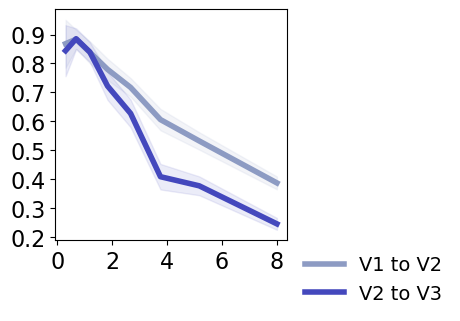

In [35]:
plt.style.use('default')
plt.figure(figsize=(3,3))
plt.plot(bin_edges[1::], eccbin_corr_mean[0], color='#8d9bc3', label='V1 to V2', lw=4)
plt.fill_between(bin_edges[1::], np.array(eccbin_corr_mean[0]) - 1.96*np.array(eccbin_corr_std[0]), 
            np.array(eccbin_corr_mean[0]) + 1.96*np.array(eccbin_corr_std[0]), color='#8d9bc3', alpha=0.1)

plt.plot(bin_edges[1::], eccbin_corr_mean[1], color='#4448bd', label='V2 to V3', lw=4)
plt.fill_between(bin_edges[1::], np.array(eccbin_corr_mean[1]) - 1.96*np.array(eccbin_corr_std[1]), 
            np.array(eccbin_corr_mean[1]) + 1.96*np.array(eccbin_corr_std[1]), color='#4448bd', alpha=0.1)
plt.legend(frameon=False,  bbox_to_anchor=(1, 0.01),loc='upper left',fontsize=14)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{space}_hierachical-distance-inecc.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)

plt.show()

In [108]:
np.unique(sector_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [32]:
# Calculate the angle of each point from the x-axis
angles = np.arctan2(yy, xx)
# Shift the angles to the range [0, 2*pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)
# Divide into 12 sectors, each covering 30 degrees (pi/6 radians)
num_bins = 21
sector_edges = np.linspace(0, 2 * np.pi, num_bins)
sector_labels = np.digitize(angles, sector_edges) - 1
# Adjust so that sectors start at the positive x-axis (0 degrees)
sector_labels[sector_labels == 20] = 0
corr_matrices = [corr_matrix_v1v2, corr_matrix_v2v3]
angbin_corr_mean = np.zeros((2, num_bins - 1))
angbin_corr_std =  np.zeros((2, num_bins - 1))
for i, corr_matrix in enumerate(corr_matrices):
    for ibin in range(num_bins - 1):
        angbin_cor = corr_matrix[np.where((sector_labels == ibin) & (xx**2 + yy**2 < 64))]
        angbin_corr_mean[i,ibin] = np.nanmean(angbin_cor)
        angbin_corr_std[i,ibin] = np.nanstd(angbin_cor)/np.sqrt(len(angbin_cor) - np.isnan(angbin_cor).sum())

In [119]:
draw_line2

array([0.34704863, 0.47846136, 0.37494875, 0.33023505, 0.24392914,
       0.16689682, 0.31513548, 0.32199826, 0.3897195 , 0.44271121,
       0.25885973, 0.54190697, 0.42729102, 0.31369616, 0.26864357,
       0.25193444, 0.35358296, 0.34336453, 0.33087924, 0.24581839,
       0.34704863])

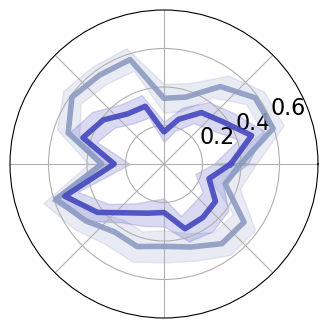

In [34]:
# Plot mean values in polar coordinates
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(polar=True)

# Plot each sector's mean radius
angles = np.linspace(0, 2 * np.pi, 21)  # Same sector edges

draw_line = np.append(angbin_corr_mean[0], angbin_corr_mean[0][0])
ax.plot(angles, draw_line, alpha=0.9,  color='#8d9bc3', label='V1 to V2', lw=4)
lower = np.array(angbin_corr_mean[0]) - 1.96*np.array(angbin_corr_std[0])
lower = np.append(lower, lower[0])
upper = np.array(angbin_corr_mean[0]) + 1.96*np.array(angbin_corr_std[0])
upper = np.append(upper, upper[0])
ax.fill_between(angles, lower, upper, color='#8d9bc3', alpha=0.2)

draw_line2 = np.append(angbin_corr_mean[1], angbin_corr_mean[1][0])
ax.plot(angles, draw_line2, alpha=0.9,  color='#4448bd', label='V2 to V3', lw=4)
lower = np.array(angbin_corr_mean[1]) - 1.96*np.array(angbin_corr_std[1])
lower = np.append(lower, lower[0])
upper = np.array(angbin_corr_mean[1]) + 1.96*np.array(angbin_corr_std[1])
upper = np.append(upper, upper[0])
ax.fill_between(angles, lower, upper, color='#4448bd', alpha=0.2)
ax.set_ylim([0, 0.8])
ax.set_yticks([0.2,0.4,0.6])
ax.set_xticklabels([])
plt.yticks(fontsize=16)
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{space}_hierachical-distance-inang.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)

# plt.title("Mean Radius of Each Sector in Polar Coordinates")
plt.show()

###  计算prior和dnn retinotopy的相关

In [97]:
def transfer_ang(theta):
    new_theta = 90 - theta
    new_theta = new_theta % 360
    return new_theta

In [88]:
allsub_param_corr = np.nan * np.zeros((9, 2))

for isub, sub in enumerate(subs):
    prior_prf = nib.load(pjoin(masked_retino_path, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()
    dnn_prf = nib.load(pjoin(masked_retino_path, sub, f'{sub}_new-weighted-masked-dnn-prf.dscalar.nii')).get_fdata()

    voxels = np.where(prior_prf[1] >= 0 )[0]
    prior_prf = prior_prf[:, voxels]
    dnn_prf = dnn_prf[:, voxels]

    prior_ang = prior_prf[0]
    prior_ecc = prior_prf[1]
    dnn_ang = transfer_ang(dnn_prf[1])
    # print(dnn_ang[0:3], prior_ang[0:3])
    dnn_ecc = dnn_prf[0]

    ang_corr = np.mean(np.cos(np.radians((dnn_ang - prior_ang))))
    # ang_corr = np.corrcoef(prior_ang, dnn_ang)[0, 1]
    ecc_corr = np.corrcoef(prior_ecc, dnn_ecc)[0,1]

    allsub_param_corr[isub, 0] = ang_corr
    allsub_param_corr[isub, 1] = ecc_corr

    

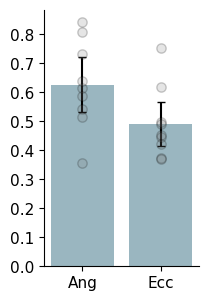

In [106]:
sems = np.std(allsub_param_corr,axis=0) / 3 * 1.96
colors = ["#9ab6c0","#9ab6c0"]
params = np.arange(2)
meandata = np.nanmean(allsub_param_corr, axis=0)
scale = 1.5
fig, ax = plt.subplots(figsize=(3/scale,5/scale))

bar = plt.bar(params, meandata, color=colors, yerr=sems, capsize=3)
for i in range(len(subs)):
    param = allsub_param_corr[i, :]
    for idx in range(len(params)):
        plt.scatter(params[idx], param[idx], s=45, color='grey', alpha=0.2, edgecolor='black', linewidth=1, zorder=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gcf().set_facecolor('white')
plt.yticks(fontsize=11)
plt.xticks([0, 1], ['Ang', 'Ecc'], fontsize=11)
# plt.savefig(pjoin(savefig_path, 'dnnprf.png'), dpi=300, bbox_inches='tight')
layer, space = 'conv2', 'pca'
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{space}_PRF-similarity.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)

plt.show()

### 3个ROI中ECC和rfsize的关系

In [95]:
from scipy.stats import linregress
subs = [f'sub-{i:02d}' for i in range(1, 10)]
sub= subs[0]
work_dir = '/nfs/z1/userhome/zzl-xsk/Featurespace'
retino_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
cifti_path = '/nfs/z1/userhome/zzl-xsk/NOD/derivatives/ciftify'
mask_name = 'primaryvis-in-MMP'
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
voxel_mask_nii = nib.load(pjoin(voxel_mask_path, f'nod-voxmask_{mask_name}.dlabel.nii'))
voxel_mask = voxel_mask_nii.get_fdata()
named_maps = [named_map.map_name for named_map in voxel_mask_nii.header.get_index_map(0).named_maps]
# determine the mask type
if sub in named_maps:
    voxel_mask = voxel_mask[named_maps.index(sub),:]
# squeeze into 1 dim
voxel_mask = np.squeeze(np.array(voxel_mask))
# transfer mask into indices
voxel_indices = np.where(voxel_mask==1)[0]

In [96]:
dnn_prf =  nib.load(pjoin(retino_dir, 'nod_new-weighted-dnn-mean-prf.dscalar.nii')).get_fdata()
dnn_ecc = dnn_prf[0, :]
dnn_rfsize = dnn_prf[2, :]
v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
v1_dnn_ecc = dnn_ecc[v1_voxels]

In [97]:
#准备数据
roinames = ['V1', 'V2', 'V3']
all_data = []
for roi in roinames:
    roidata = []
    for sub in subs:
        dnn_prf =  nib.load(pjoin(retino_dir, 'nod_new-weighted-dnn-mean-prf.dscalar.nii')).get_fdata()
        # dnn_prf =  nib.load(pjoin(retino_dir, 'nod_prior-mean-prf.dscalar.nii')).get_fdata()
        dnn_ecc = dnn_prf[0, :]
        dnn_rfsize = dnn_prf[2, :]
        voxels = np.array([ _ for _ in np.where(get_roi_data(None, roi)==1)[0] if _ in voxel_indices])
        select_voxels = [_ for _ in voxels if dnn_ecc[_] > 0 and dnn_rfsize[_] > 0 and dnn_rfsize[_] < 30]
        for v in select_voxels:
            voxel_ecc = dnn_ecc[v]
            voxel_rfsize = dnn_rfsize[v]
            roidata.append([voxel_ecc, voxel_rfsize])
    all_data.append(roidata)

In [98]:
#准备数据
all_data = []
for roi in roinames:
    roidata = []
    for sub in subs:
        dnn_prf =  nib.load(pjoin(retino_dir, 'nod_new-weighted-dnn-mean-prf.dscalar.nii')).get_fdata()
        # dnn_prf =  nib.load(pjoin(retino_dir, 'nod_prior-mean-prf.dscalar.nii')).get_fdata()
        dnn_ecc = dnn_prf[0, :]
        dnn_rfsize = dnn_prf[2, :]
        voxels = np.array([ _ for _ in np.where(get_roi_data(None, roi)==1)[0] if _ in voxel_indices])
        select_voxels = [_ for _ in voxels if dnn_ecc[_] > 0 and dnn_rfsize[_] > 0 and dnn_rfsize[_] < 30]
        for v in select_voxels:
            voxel_ecc = dnn_ecc[v]
            voxel_rfsize = dnn_rfsize[v]
            roidata.append([voxel_ecc, voxel_rfsize])
    all_data.append(roidata)

In [99]:
grid = 5
v1_datas = np.array(all_data[0])
v1_ecc = v1_datas[:, 0]
v1_rfsize = v1_datas[:, 1]
sorted_indices = np.argsort(v1_ecc)
v1_ecc = v1_ecc[sorted_indices]
v1_rfsize =v1_rfsize[sorted_indices]
# 分成10份
ecc_splits = np.array_split(v1_ecc, grid)
rfsize_splits = np.array_split(v1_rfsize, grid) 
# 计算每一份的平均值
v1_ecc_mean = np.array([np.mean(split) for split in ecc_splits])
v1_rfsize_mean = np.array([np.mean(split) for split in rfsize_splits])

v2_datas = np.array(all_data[1])
v2_ecc = v2_datas[:, 0]
v2_rfsize = v2_datas[:, 1]
sorted_indices = np.argsort(v2_ecc)
v2_ecc = v2_ecc[sorted_indices]
v2_rfsize =v2_rfsize[sorted_indices]
# 分成10份
ecc_splits = np.array_split(v2_ecc, grid)
rfsize_splits = np.array_split(v2_rfsize, grid) 
# 计算每一份的平均值
v2_ecc_mean = np.array([np.mean(split) for split in ecc_splits])
v2_rfsize_mean = np.array([np.mean(split) for split in rfsize_splits])

v3_datas = np.array(all_data[2])
v3_ecc = v3_datas[:, 0]
v3_rfsize = v3_datas[:, 1]
sorted_indices = np.argsort(v3_ecc)
v3_ecc = v3_ecc[sorted_indices]
v3_rfsize =v3_rfsize[sorted_indices]
# 分成10份
ecc_splits = np.array_split(v3_ecc, grid)
rfsize_splits = np.array_split(v3_rfsize, grid) 
# 计算每一份的平均值
v3_ecc_mean = np.array([np.mean(split) for split in ecc_splits])
v3_rfsize_mean = np.array([np.mean(split) for split in rfsize_splits])

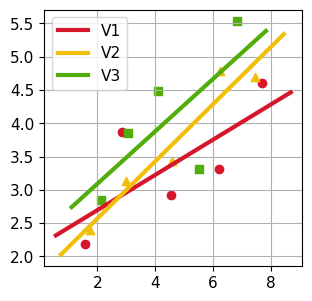

In [105]:
scale = 1.5
ax, fig = plt.subplots(figsize=(5/scale,5/scale))
colors = ["#d6162a","#f0be0b","#51ad0a"]
plt.scatter(v1_ecc_mean , v1_rfsize_mean,color=colors[0], marker='o')
plt.scatter(v2_ecc_mean, v2_rfsize_mean, color=colors[1], marker='^')
plt.scatter(v3_ecc_mean, v3_rfsize_mean, color=colors[2], marker='s')
# 对 V1 拟合直线
coeffs_v1 = np.polyfit(v1_ecc_mean, v1_rfsize_mean, 1)
x_v1 = np.linspace(min(v1_ecc_mean) - 1, max(v1_ecc_mean) + 1, 100)
line_v1 = np.polyval(coeffs_v1, x_v1)
plt.plot(x_v1, line_v1, color=colors[0], label='V1', linewidth=3)

# 对 V2 拷贝相同代码
coeffs_v2 = np.polyfit(v2_ecc_mean, v2_rfsize_mean, 1)
x_v2 = np.linspace(min(v2_ecc_mean) - 1, max(v2_ecc_mean) + 1, 100)
line_v2 = np.polyval(coeffs_v2, x_v2)
plt.plot(x_v2, line_v2, color=colors[1], label='V2', linewidth=3)

# 对 V3 拟合直线
coeffs_v3 = np.polyfit(v3_ecc_mean, v3_rfsize_mean, 1)
x_v3 = np.linspace(min(v3_ecc_mean) - 1, max(v3_ecc_mean) + 1, 100)
line_v3 = np.polyval(coeffs_v3, x_v3)
plt.plot(x_v3, line_v3, color=colors[2], label='V3', linewidth=3)

# plt.xlim([0, 7])
plt.grid()
plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.xlabel('Eccentricity', fontsize=15)
# plt.ylabel('RFsize', fontsize=15)
plt.gcf().set_facecolor('white')
layer, space = 'conv2', 'pca'
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{space}_siezwithecc.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)
# plt.savefig(pjoin(savefig_path, 'rfsize.png'), dpi=300, bbox_inches='tight')
plt.show()